# Using CodeCharta Files with Custom Metrics for Deeper Analysis

Have you ever wanted to quickly enrich a [CodeCharta](https://codecharta.com/) visualization with custom metrics — without building your own tooling from scratch?

In this post, I’ll show you a simple Python-based approach to load, modify, and re-export CodeCharta JSON files, making it easy to experiment with additional attributes like synthetic coverage scores or quality indicators.

## About

CodeCharta is a great tool for visualizing software metrics as 3D maps. But sometimes, you want to:
- Add new data points (like production coverage or manually created risk scores).
- Post-process metrics from external analysis results.
- Play with custom metrics for certain exploratory purposes.

This Python script demonstrates:
1. Load existing CodeCharta JSON files into a DataFrame.
2. Easily add new attributes — for example, a column of random values between 0 and 1, rounded to two decimal places.
3. Export the enhanced dataset back into the original nested JSON structure that CodeCharta understands.

_Note: This is just for demonstration purposes only. The main parts are also just vibe coded by ChatGPT 4o._

## Demo

### Helper methods
vibe coded

In [1]:
#vibe coded
import json
import os
import pandas as pd
import numpy as np

def load_cc_json(file_path):
    with open(file_path, "r") as f:
        json_data = json.load(f)
    df = pd.DataFrame(flatten_nodes(json_data["data"]["nodes"]))
    return df

def flatten_nodes(nodes, parent_path=""):
    rows = []
    for node in nodes:
        current_path = f"{parent_path}/{node['name']}".lstrip('/')
        if node["type"] == "File":
            row = {"path": current_path}
            row.update(node.get("attributes", {}))
            rows.append(row)
        if node.get("children"):
            rows.extend(flatten_nodes(node["children"], current_path))
    return rows

def build_nested_tree(df):
    tree = {}

    for _, row in df.iterrows():
        parts = row["path"].split("/")
        current_level = tree
        for i, part in enumerate(parts):
            if part not in current_level:
                current_level[part] = {"__children": {}, "__attributes": {}}
            if i == len(parts) - 1:
                attributes = {k: v for k, v in row.drop("path").dropna().items()}
                current_level[part]["__attributes"].update(attributes)
            current_level = current_level[part]["__children"]

    def convert_to_nodestruct(name, node):
        children = [convert_to_nodestruct(child_name, child_node) for child_name, child_node in node["__children"].items()]
        node_type = "File" if node["__attributes"] else "Folder"
        return {
            "name": name,
            "type": node_type,
            "attributes": node["__attributes"],
            "children": children
        }

    root_children = [convert_to_nodestruct(name, node) for name, node in tree.items()]
    return {"name": "root", "type": "Folder", "attributes": {}, "children": root_children}

def export_enhanced_codecharta(df, original_file_path):
    with open(original_file_path) as f:
        original_json = json.load(f)

    nested_root = build_nested_tree(df)

    enhanced_json = {
        "data": {
            "projectName": original_json["data"].get("projectName", ""),
            "nodes": [nested_root],
            "edges": original_json["data"].get("edges", []),
            "attributeTypes": original_json["data"].get("attributeTypes", {}),
            "blacklist": original_json["data"].get("blacklist", []),
            "apiVersion": original_json["data"].get("apiVersion", "1.3")
        },
        "checksum": original_json.get("checksum", "")
    }

    base, ext = os.path.splitext(original_file_path)
    enhanced_file_path = f"{base}_enhanced{ext}"

    with open(enhanced_file_path, "w") as f:
        json.dump(enhanced_json, f, indent=4)
    print(f"✅ Exported enhanced file to: {enhanced_file_path}")

### Load an existing analysis file 
(file was created by CodeCharta's command line util)

In [2]:
path = "openclinica.git.source.cc.json"
df = load_cc_json(path)
df.head()

,path,number_of_authors,number_of_commits,range_of_weeks_with_commits,weeks_with_commits,highly_coupled_files,median_coupled_files,number_of_renames,age_in_weeks,rloc,...,comment_lines,complexity,cognitive_complexity,commented_out_code_blocks,max_nesting_level,code_smell,security_hotspot,vulnerability,bug,sonar_issue_other
0,root/core/pom.xml,17.0,169.0,693.0,91.0,4.0,4.0,0.0,141.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,root/core/src/main/java/org/akaza/openclinica/...,3.0,3.0,278.0,3.0,0.0,7.0,0.0,518.0,181.0,...,2.0,53.0,10.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0
2,root/core/src/main/java/org/akaza/openclinica/...,1.0,1.0,1.0,1.0,0.0,5023.0,0.0,795.0,144.0,...,56.0,35.0,2.0,0.0,1.0,15.0,0.0,0.0,1.0,0.0
3,root/core/src/main/java/org/akaza/openclinica/...,2.0,4.0,127.0,3.0,0.0,25.0,0.0,669.0,63.0,...,17.0,16.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
4,root/core/src/main/java/org/akaza/openclinica/...,2.0,2.0,278.0,2.0,0.0,2515.0,0.0,518.0,46.0,...,1.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Do some analysis stuff
Just plot a simplte pie chart for the source code files with the most amount of code lines.

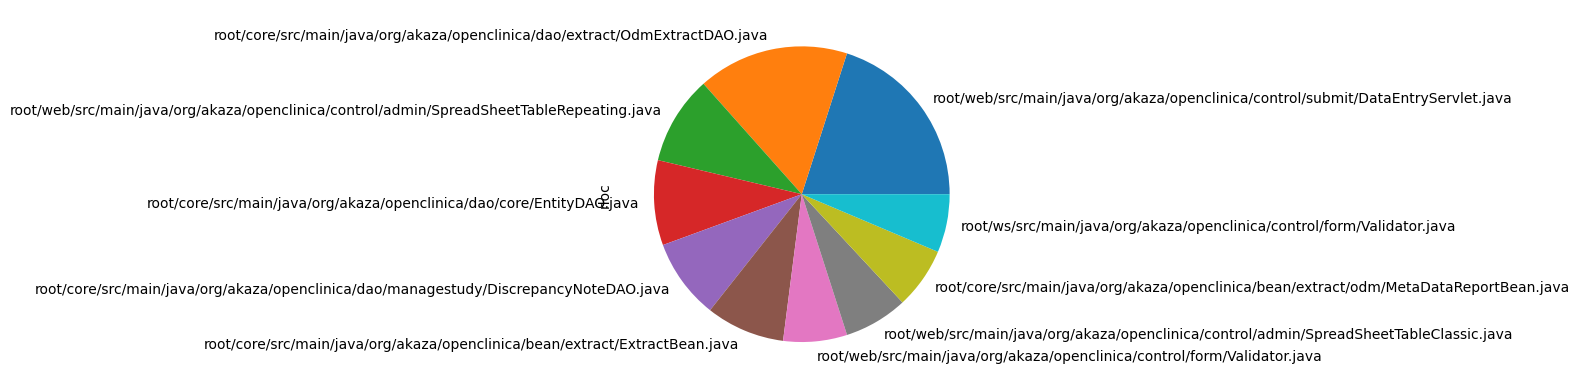

In [3]:
top10 = df.set_index('path')['rloc'].sort_values(ascending=False).head(10)
top10.plot.pie();

### Add your additional stuff
(for this demo, just added some random values)

In [4]:
df["random_coverage"] = [round(np.random.rand(), 2) * 100.0 for _ in range(len(df))]
df.head()

,path,number_of_authors,number_of_commits,range_of_weeks_with_commits,weeks_with_commits,highly_coupled_files,median_coupled_files,number_of_renames,age_in_weeks,rloc,...,complexity,cognitive_complexity,commented_out_code_blocks,max_nesting_level,code_smell,security_hotspot,vulnerability,bug,sonar_issue_other,random_coverage
0,root/core/pom.xml,17.0,169.0,693.0,91.0,4.0,4.0,0.0,141.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0
1,root/core/src/main/java/org/akaza/openclinica/...,3.0,3.0,278.0,3.0,0.0,7.0,0.0,518.0,181.0,...,53.0,10.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,70.0
2,root/core/src/main/java/org/akaza/openclinica/...,1.0,1.0,1.0,1.0,0.0,5023.0,0.0,795.0,144.0,...,35.0,2.0,0.0,1.0,15.0,0.0,0.0,1.0,0.0,86.0
3,root/core/src/main/java/org/akaza/openclinica/...,2.0,4.0,127.0,3.0,0.0,25.0,0.0,669.0,63.0,...,16.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,38.0
4,root/core/src/main/java/org/akaza/openclinica/...,2.0,2.0,278.0,2.0,0.0,2515.0,0.0,518.0,46.0,...,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


### Export enhanced data

In [5]:
export_enhanced_codecharta(df, path)

✅ Exported enhanced file to: openclinica.git.source.cc_enhanced.json
